In [ ]:
# 1. Import necessary libraries:

library(tidyverse)  # For data manipulation and visualization
library(caret)      # For creating data partitions
library(broom)      # For tidying up model outputs
library(plotly)     # For interactive visualizations
library(dplyr)      # For data manipulation
library(tidyr)      # For data manipulation
library(ggplot2)    # For data visualization
library(corrplot)   # For correlation plot

library(randomForest)
library(glmnet)   # For Ridge, Lasso, and Elastic Net
library(gbm)      # For Gradient Boosting
library(e1071)    # For SVM
library(neuralnet) # For Neural Networks


In [ ]:
# 2. Load the dataset:

library(readxl)
df <- read_excel("powerconsumption.xlsx")

head(df)


Datetime,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,PowerConsumption_Zone1,PowerConsumption_Zone2,PowerConsumption_Zone3
<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2017-01-01 00:00:00,6.559,73.8,0.083,0.051,0.119,34055.70,16128.88,20240.96
2017-01-01 00:10:00,6.414,74.5,0.083,0.070,0.085,29814.68,19375.08,20131.08
2017-01-01 00:20:00,6.313,74.5,0.080,0.062,0.100,29128.10,19006.69,19668.43
2017-01-01 00:30:00,6.121,75.0,0.083,0.091,0.096,28228.86,18361.09,18899.28
2017-01-01 00:40:00,5.921,75.7,0.081,0.048,0.085,27335.70,17872.34,18442.41
2017-01-01 00:50:00,5.853,76.9,0.081,0.059,0.108,26624.81,17416.41,18130.12


In [ ]:
#3. Data Inspection and Cleaning:

# Data shape
dim(df)

# Calculate mean of PowerConsumption_Zone1, PowerConsumption_Zone2, and PowerConsumption_Zone3
df <- df %>% mutate(PowerConsumption_Zone = rowMeans(select(., starts_with('PowerConsumption_Zone'))))
head(df)

# Check for missing values
colSums(is.na(df))

# Check for duplicate rows
sum(duplicated(df))

# Summary statistics
summary(df)


[1] 52416     9

Datetime,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,PowerConsumption_Zone1,PowerConsumption_Zone2,PowerConsumption_Zone3,PowerConsumption_Zone
<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2017-01-01 00:00:00,6.559,73.8,0.083,0.051,0.119,34055.70,16128.88,20240.96,23475.18
2017-01-01 00:10:00,6.414,74.5,0.083,0.070,0.085,29814.68,19375.08,20131.08,23106.95
2017-01-01 00:20:00,6.313,74.5,0.080,0.062,0.100,29128.10,19006.69,19668.43,22601.07
2017-01-01 00:30:00,6.121,75.0,0.083,0.091,0.096,28228.86,18361.09,18899.28,21829.74
2017-01-01 00:40:00,5.921,75.7,0.081,0.048,0.085,27335.70,17872.34,18442.41,21216.82
2017-01-01 00:50:00,5.853,76.9,0.081,0.059,0.108,26624.81,17416.41,18130.12,20723.78


Datetime            Temperature               Humidity 
                     0                      0                      0 
             WindSpeed    GeneralDiffuseFlows           DiffuseFlows 
                     0                      0                      0 
PowerConsumption_Zone1 PowerConsumption_Zone2 PowerConsumption_Zone3 
                     0                      0                      0 
 PowerConsumption_Zone 
                     0

[1] 0

    Datetime                    Temperature        Humidity       WindSpeed    
 Min.   :2017-01-01 00:00:00   Min.   : 3.247   Min.   :11.34   Min.   :0.050  
 1st Qu.:2017-04-01 23:57:30   1st Qu.:14.410   1st Qu.:58.31   1st Qu.:0.078  
 Median :2017-07-01 23:55:00   Median :18.780   Median :69.86   Median :0.086  
 Mean   :2017-07-01 23:55:00   Mean   :18.810   Mean   :68.26   Mean   :1.959  
 3rd Qu.:2017-09-30 23:52:30   3rd Qu.:22.890   3rd Qu.:81.40   3rd Qu.:4.915  
 Max.   :2017-12-30 23:50:00   Max.   :40.010   Max.   :94.80   Max.   :6.483  
 GeneralDiffuseFlows  DiffuseFlows     PowerConsumption_Zone1
 Min.   :   0.004    Min.   :  0.011   Min.   :13896         
 1st Qu.:   0.062    1st Qu.:  0.122   1st Qu.:26311         
 Median :   5.035    Median :  4.456   Median :32266         
 Mean   : 182.697    Mean   : 75.028   Mean   :32345         
 3rd Qu.: 319.600    3rd Qu.:101.000   3rd Qu.:37309         
 Max.   :1163.000    Max.   :936.000   Max.   :52204         
 Power

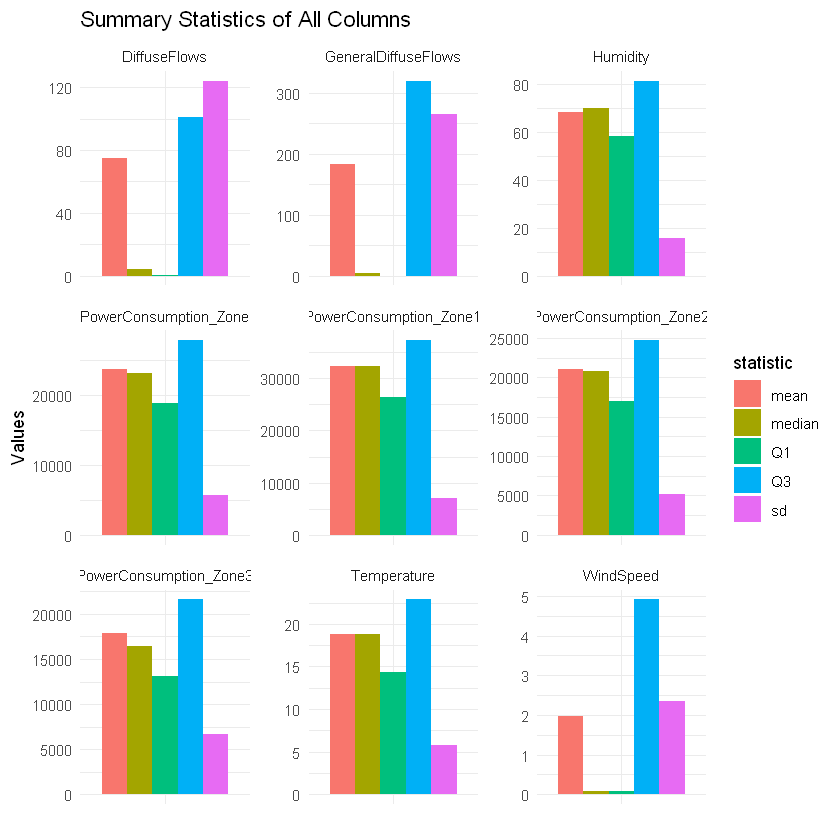

In [ ]:
# 4. Visualizing Data Distribution:

# Exclude 'Datetime' and ensure only numeric columns are summarized
all_column_stats <- df %>%
  select(where(is.numeric)) %>%
  summarise(across(everything(), list(mean = mean, sd = sd, median = median, Q1 = ~quantile(.x, 0.25), Q3 = ~quantile(.x, 0.75))))

# Convert to long format for ggplot
all_column_stats_long <- pivot_longer(
  all_column_stats, 
  cols = everything(), 
  names_to = c("variable", "statistic"), 
  names_pattern = "(.*)_(.*)"
)

# Create bar plots using ggplot2
all_column_stats_long %>%
  ggplot(aes(x = variable, y = value, fill = statistic)) +
  geom_bar(stat = "identity", position = "dodge") +
  facet_wrap(~ variable, scales = "free") +
  theme_minimal() +
  labs(title = "Summary Statistics of All Columns", x = "", y = "Values") +
  theme(axis.text.x = element_blank(), axis.ticks.x = element_blank())


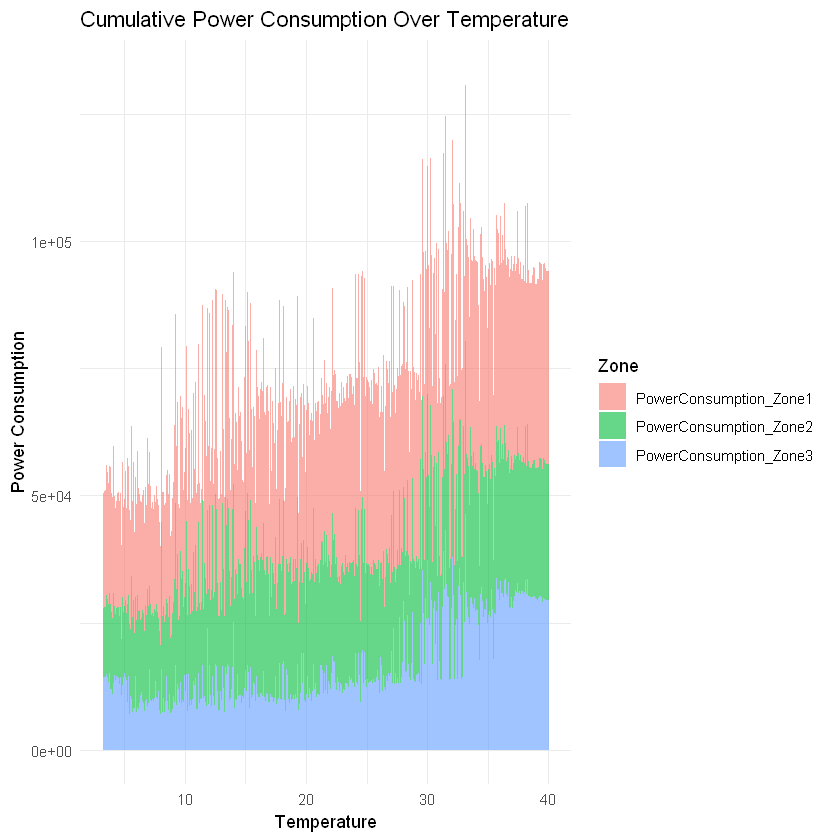

In [ ]:
# Cumulative Power Consumption Over Temperature
df %>%
  gather(key = "Zone", value = "PowerConsumption", PowerConsumption_Zone1, PowerConsumption_Zone2, PowerConsumption_Zone3) %>%
  ggplot(aes(x = Temperature, y = PowerConsumption, fill = Zone)) +
  geom_area(alpha = 0.6) +
  theme_minimal() +
  labs(title = "Cumulative Power Consumption Over Temperature", x = "Temperature", y = "Power Consumption")


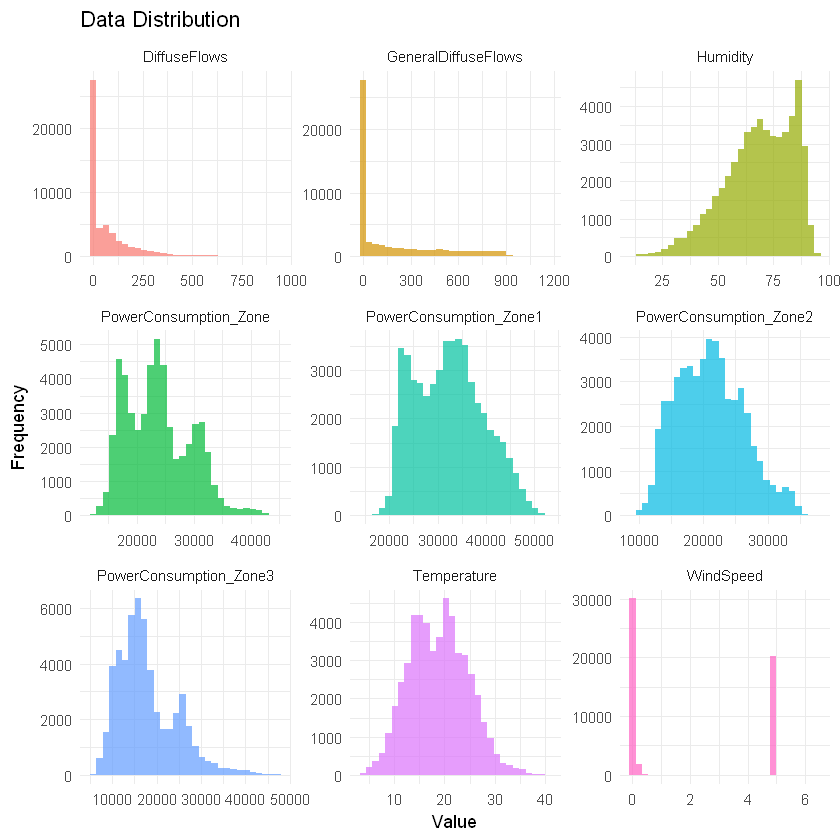

In [ ]:
# Data Distribution Plots

df %>%
  select(Temperature, Humidity, WindSpeed, GeneralDiffuseFlows, DiffuseFlows,
         PowerConsumption_Zone1, PowerConsumption_Zone2, PowerConsumption_Zone3, PowerConsumption_Zone) %>%
  gather(key = "Variable", value = "Value") %>%
  ggplot(aes(x = Value, fill = Variable)) +
  geom_histogram(bins = 30, alpha = 0.7) +
  facet_wrap(~ Variable, scales = 'free', ncol = 3) +
  theme_minimal() +
  labs(title = "Data Distribution", x = "Value", y = "Frequency") +
  theme(legend.position = "none")


`geom_smooth()` using formula = 'y ~ x'


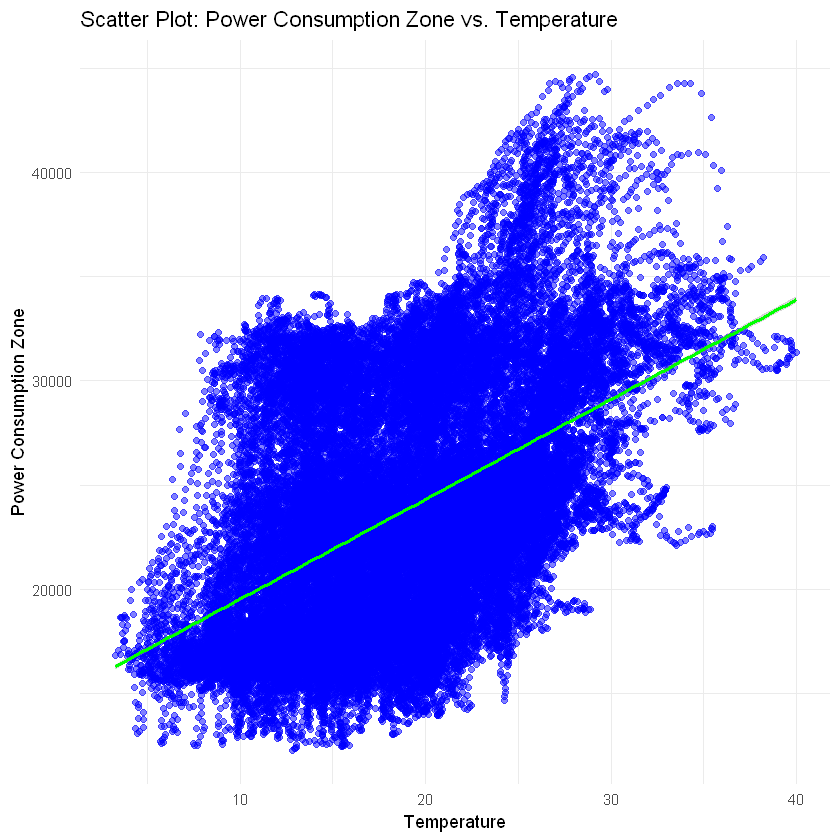

In [ ]:
# Scatter Plot: Power Consumption Zone vs. Temperature
df %>%
  ggplot(aes(x = Temperature, y = PowerConsumption_Zone)) +
  geom_point(color = 'blue', alpha = 0.5) +
  geom_smooth(method = 'lm', color = 'green') +
  theme_minimal() +
  labs(title = "Scatter Plot: Power Consumption Zone vs. Temperature", x = "Temperature", y = "Power Consumption Zone")


`geom_smooth()` using formula = 'y ~ x'


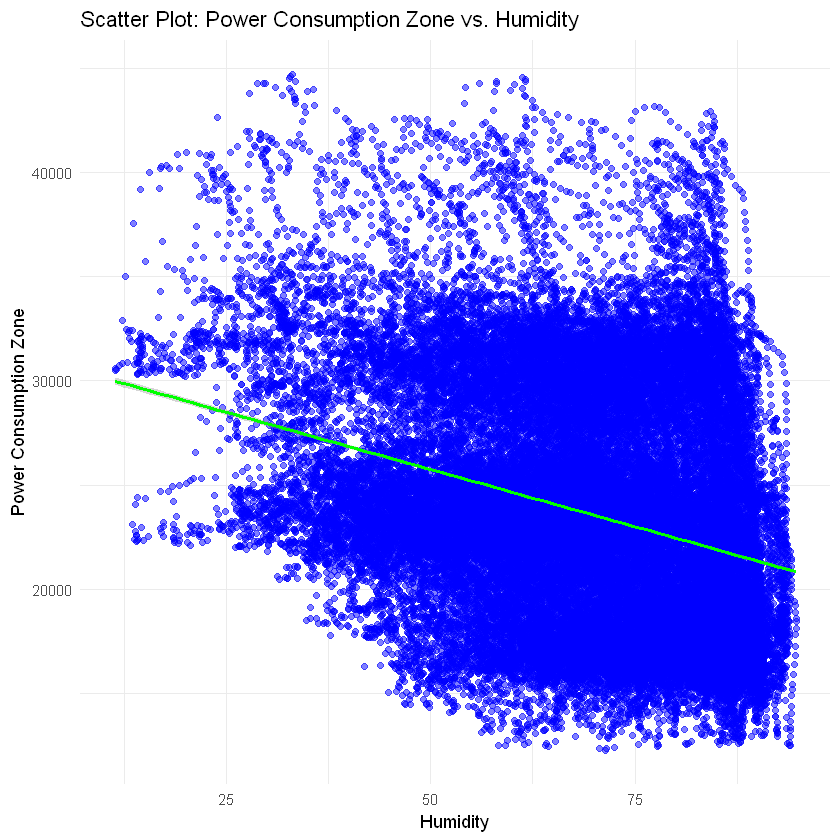

In [ ]:
# Scatter Plot: Power Consumption Zone vs. Humidity
df %>%
  ggplot(aes(x = Humidity, y = PowerConsumption_Zone)) +
  geom_point(color = 'blue', alpha = 0.5) +
  geom_smooth(method = 'lm', color = 'green') +
  theme_minimal() +
  labs(title = "Scatter Plot: Power Consumption Zone vs. Humidity", x = "Humidity", y = "Power Consumption Zone")


`geom_smooth()` using formula = 'y ~ x'


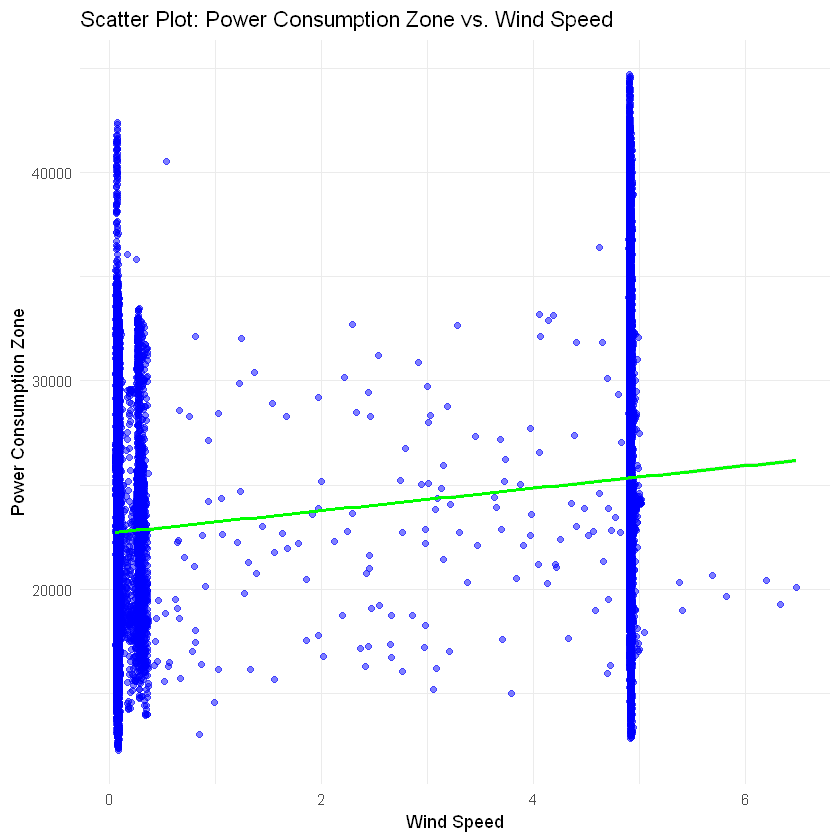

In [ ]:
# Scatter Plot: Power Consumption Zone vs. Wind Speed
df %>%
  ggplot(aes(x = WindSpeed, y = PowerConsumption_Zone)) +
  geom_point(color = 'blue', alpha = 0.5) +
  geom_smooth(method = 'lm', color = 'green') +
  theme_minimal() +
  labs(title = "Scatter Plot: Power Consumption Zone vs. Wind Speed", x = "Wind Speed", y = "Power Consumption Zone")


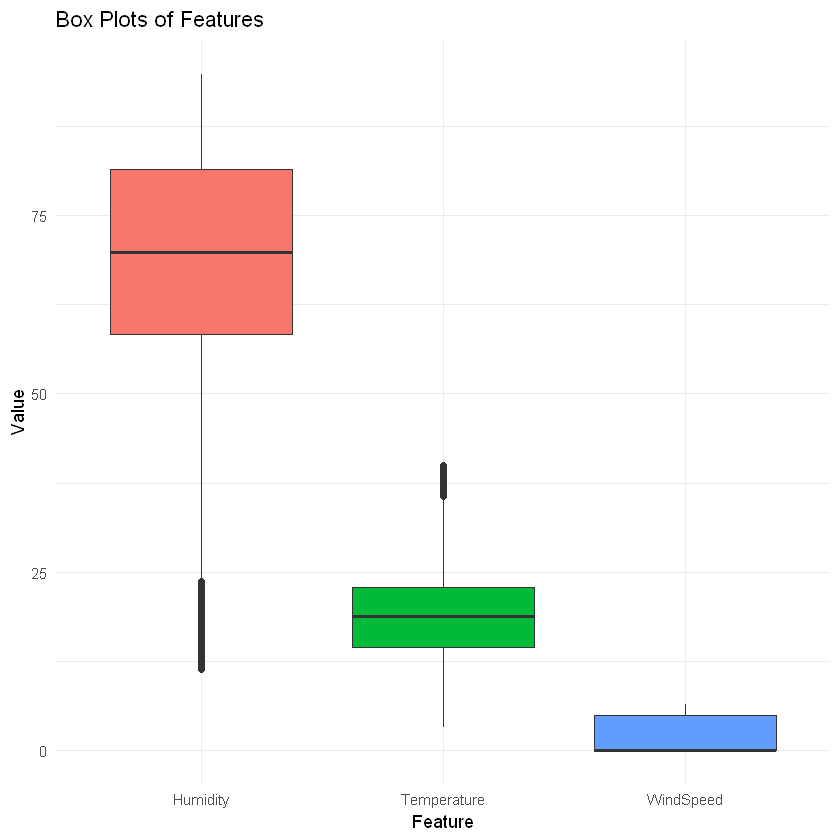

In [ ]:
# Box Plots of Features (Temperature, Humidity, Wind Speed)
df %>%
  select(Temperature, Humidity, WindSpeed) %>%
  gather(key = "Feature", value = "Value") %>%
  ggplot(aes(x = Feature, y = Value, fill = Feature)) +
  geom_boxplot() +
  theme_minimal() +
  labs(title = "Box Plots of Features", x = "Feature", y = "Value") +
  theme(legend.position = "none")


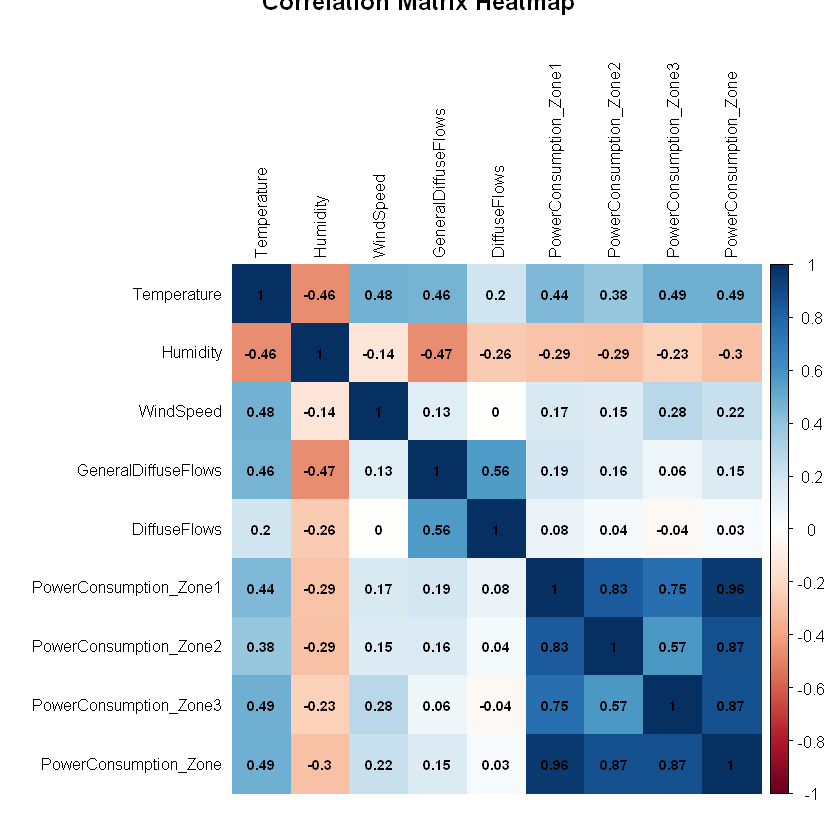

In [ ]:
# Correlation Matrix Heatmap
library(corrplot)

# Calculate the correlation matrix
cor_matrix <- df %>%
  select(Temperature, Humidity, WindSpeed, GeneralDiffuseFlows, DiffuseFlows,
         PowerConsumption_Zone1, PowerConsumption_Zone2, PowerConsumption_Zone3, PowerConsumption_Zone) %>%
  cor()

# Plot the correlation matrix
corrplot(cor_matrix, method = "color", tl.cex = 0.8, tl.col = "black", addCoef.col = "black", number.cex = 0.7, title = "Correlation Matrix Heatmap")


In [ ]:
# Calculate the correlation matrix
cor_matrix <- df %>%
  select(Temperature, Humidity, WindSpeed, GeneralDiffuseFlows, DiffuseFlows,
         PowerConsumption_Zone1, PowerConsumption_Zone2, PowerConsumption_Zone3, PowerConsumption_Zone) %>%
  cor()


In [ ]:
# Convert the correlation matrix to a tidy format
cor_matrix_tidy <- as.data.frame(as.table(cor_matrix))


In [ ]:
# Extract high correlation pairs (absolute value > 0.6)
high_corr_pairs <- cor_matrix_tidy %>%
  filter(abs(Freq) > 0.6 & abs(Freq) < 1) %>%  # Exclude self-correlations
  arrange(desc(abs(Freq)))

# Output high correlation pairs
cat("High Correlation Pairs:\n")
print(high_corr_pairs)


High Correlation Pairs:
                     Var1                   Var2      Freq
1   PowerConsumption_Zone PowerConsumption_Zone1 0.9591455
2  PowerConsumption_Zone1  PowerConsumption_Zone 0.9591455
3   PowerConsumption_Zone PowerConsumption_Zone3 0.8717774
4  PowerConsumption_Zone3  PowerConsumption_Zone 0.8717774
5   PowerConsumption_Zone PowerConsumption_Zone2 0.8710694
6  PowerConsumption_Zone2  PowerConsumption_Zone 0.8710694
7  PowerConsumption_Zone2 PowerConsumption_Zone1 0.8345189
8  PowerConsumption_Zone1 PowerConsumption_Zone2 0.8345189
9  PowerConsumption_Zone3 PowerConsumption_Zone1 0.7507335
10 PowerConsumption_Zone1 PowerConsumption_Zone3 0.7507335


In [ ]:
# Extract low correlation pairs (absolute value < 0.11)
low_corr_pairs <- cor_matrix_tidy %>%
  filter(abs(Freq) < 0.11) %>%
  arrange(abs(Freq))

# Output low correlation pairs
cat("\nLow Correlation Pairs:\n")
print(low_corr_pairs)



Low Correlation Pairs:


                     Var1                   Var2          Freq
1            DiffuseFlows              WindSpeed -0.0009720357
2               WindSpeed           DiffuseFlows -0.0009720357
3   PowerConsumption_Zone           DiffuseFlows  0.0320676468
4            DiffuseFlows  PowerConsumption_Zone  0.0320676468
5  PowerConsumption_Zone3           DiffuseFlows -0.0385057156
6            DiffuseFlows PowerConsumption_Zone3 -0.0385057156
7  PowerConsumption_Zone2           DiffuseFlows  0.0446668761
8            DiffuseFlows PowerConsumption_Zone2  0.0446668761
9  PowerConsumption_Zone3    GeneralDiffuseFlows  0.0633759045
10    GeneralDiffuseFlows PowerConsumption_Zone3  0.0633759045
11 PowerConsumption_Zone1           DiffuseFlows  0.0802739046
12           DiffuseFlows PowerConsumption_Zone1  0.0802739046


In [ ]:
#Data Transformation - Standardization

# Define numerical columns
numerical_columns <- c('Temperature', 'Humidity', 'WindSpeed', 'GeneralDiffuseFlows', 
                       'DiffuseFlows', 'PowerConsumption_Zone1', 'PowerConsumption_Zone2', 
                       'PowerConsumption_Zone3', 'PowerConsumption_Zone')

# Standardize the data
preProcValues <- preProcess(df[numerical_columns], method = c("center", "scale"))
df_scaled <- predict(preProcValues, df[numerical_columns])

# Display the standardized data
head(df_scaled)

Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,PowerConsumption_Zone1,PowerConsumption_Zone2,PowerConsumption_Zone3,PowerConsumption_Zone
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
-2.106625,0.3562741,-0.7988928,-0.6907903,-0.6030791,0.2399145,-0.9446633,0.36325848,-0.04651134
-2.131558,0.4012868,-0.7988928,-0.6907184,-0.6033528,-0.3548510,-0.3205698,0.34666579,-0.11095063
-2.148925,0.4012868,-0.8001700,-0.6907487,-0.6032320,-0.4511382,-0.3913939,0.27680184,-0.19947712
-2.181941,0.4334387,-0.7988928,-0.6906390,-0.6032642,-0.5772490,-0.5155114,0.16065303,-0.33445764
-2.216332,0.4784513,-0.7997443,-0.6908016,-0.6033528,-0.7025076,-0.6094760,0.09166238,-0.44171838
-2.228025,0.5556159,-0.7997443,-0.6907600,-0.6031676,-0.8022032,-0.6971296,0.04450422,-0.52799793


In [ ]:
# Normalize the data
preProcValues_norm <- preProcess(df[numerical_columns], method = c("range"))
df_normalized <- predict(preProcValues_norm, df[numerical_columns])

# Display the normalized data
head(df_normalized)


Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,PowerConsumption_Zone1,PowerConsumption_Zone2,PowerConsumption_Zone3,PowerConsumption_Zone
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.09009058,0.7483825,0.005129799,4.041286e-05,1.153860e-04,0.5262512,0.2623610,0.3433679,0.3453030
0.08614640,0.7567697,0.005129799,5.674998e-05,7.906076e-05,0.4155450,0.3748857,0.3407306,0.3339639
0.08339907,0.7567697,0.004663454,4.987119e-05,9.508659e-05,0.3976226,0.3621160,0.3296260,0.3183863
0.07817643,0.7627606,0.005129799,7.480679e-05,9.081303e-05,0.3741491,0.3397375,0.3111647,0.2946343
0.07273617,0.7711479,0.004818903,3.783332e-05,7.906076e-05,0.3508342,0.3227956,0.3001990,0.2757601
0.07088649,0.7855260,0.004818903,4.729165e-05,1.036337e-04,0.3322774,0.3069916,0.2927034,0.2605779


MODEL TRAINING AND EVALUATION

In [ ]:
#Data Preparation and Train-Test Split

# Define numerical columns
numerical_columns <- c('Temperature', 'Humidity', 'WindSpeed', 'GeneralDiffuseFlows', 
                       'DiffuseFlows', 'PowerConsumption_Zone1', 'PowerConsumption_Zone2', 
                       'PowerConsumption_Zone3', 'PowerConsumption_Zone')

# Standardize the data
preProcValues <- preProcess(df[numerical_columns], method = c("center", "scale"))
df_scaled <- predict(preProcValues, df[numerical_columns])

# Define X and y
X <- df_scaled
y <- df$PowerConsumption_Zone

# Train-Test Split
set.seed(42)
trainIndex <- createDataPartition(y, p = .8, list = FALSE)
X_train <- X[trainIndex, ]
X_test <- X[-trainIndex, ]
y_train <- y[trainIndex]
y_test <- y[-trainIndex]

In [ ]:
#Model Training and Evaluation - Linear Regression

# Model Training - Linear Regression
linear_model <- lm(y_train ~ ., data = as.data.frame(cbind(y_train, X_train)))

# Model Prediction
y_pred_lr <- predict(linear_model, as.data.frame(X_test))

# Model Evaluation
mse_lr <- mean((y_test - y_pred_lr)^2)
print(paste('Mean Squared Error for Linear Regression:', mse_lr))


[1] "Mean Squared Error for Linear Regression: 1.40384484082751e-21"


In [ ]:
#Model Training and Evaluation - Random Forest

# Model Training - Random Forest
rf_model <- randomForest(X_train, y_train, ntree = 100, random_state = 42)

# Model Prediction
y_pred_rf <- predict(rf_model, X_test)

# Model Evaluation
mse_rf <- mean((y_test - y_pred_rf)^2)
print(paste('Mean Squared Error for Random Forest:', mse_rf))



: 

In [ ]:
# Creating a Result DataFrame

# Creating a Result DataFrame
result_df <- data.frame(
  Actual = y_test,
  Predicted_LR = y_pred_lr,
  Predicted_RF = y_pred_rf
)

result_df <- result_df %>%
  mutate(
    LR_Error = abs(Actual - Predicted_LR),
    RF_Error = abs(Actual - Predicted_RF)
  )

head(result_df)

,Actual,Predicted_LR,Predicted_RF,LR_Error,RF_Error
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,23475.18,23475.18,23598.78,2.910383e-11,123.59863
2,20723.78,20723.78,20752.73,1.455192e-11,28.94407
3,19004.31,19004.31,18980.86,1.818989e-11,23.44210
4,16476.40,16476.40,16462.05,2.182787e-11,14.34873
5,16360.08,16360.08,16385.07,2.182787e-11,24.98810
6,16311.80,16311.80,16362.47,1.818989e-11,50.66380


Implementing Ridge, Lasso, and Elastic Net in R

In [ ]:
# Ridge Regression
ridge_model <- cv.glmnet(as.matrix(X_train), y_train, alpha = 0)  # alpha = 0 for Ridge
y_pred_ridge <- predict(ridge_model, s = ridge_model$lambda.min, newx = as.matrix(X_test))
mse_ridge <- mean((y_test - y_pred_ridge)^2)
print(paste('Mean Squared Error for Ridge Regression:', mse_ridge))


[1] "Mean Squared Error for Ridge Regression: 34776.3066486307"


In [ ]:
# Lasso Regression
lasso_model <- cv.glmnet(as.matrix(X_train), y_train, alpha = 1)  # alpha = 1 for Lasso
y_pred_lasso <- predict(lasso_model, s = lasso_model$lambda.min, newx = as.matrix(X_test))
mse_lasso <- mean((y_test - y_pred_lasso)^2)
print(paste('Mean Squared Error for Lasso Regression:', mse_lasso))


[1] "Mean Squared Error for Lasso Regression: 27838.9562787432"


In [ ]:
# Elastic Net
elastic_model <- cv.glmnet(as.matrix(X_train), y_train, alpha = 0.5)  # alpha = 0.5 for Elastic Net
y_pred_elastic <- predict(elastic_model, s = elastic_model$lambda.min, newx = as.matrix(X_test))
mse_elastic <- mean((y_test - y_pred_elastic)^2)
print(paste('Mean Squared Error for Elastic Net:', mse_elastic))


[1] "Mean Squared Error for Elastic Net: 29941.5625864715"


In [ ]:
# Load necessary library for Neural Networks
library(neuralnet)

# Neural Networks
nn_model <- neuralnet(y_train ~ ., data = as.data.frame(cbind(y_train, X_train)), hidden = c(5,3), linear.output = TRUE)
nn_results <- compute(nn_model, as.data.frame(X_test))
y_pred_nn <- nn_results$net.result
mse_nn <- mean((y_test - y_pred_nn)^2)
print(paste('Mean Squared Error for Neural Networks:', mse_nn))


In [ ]:
# Load necessary library for SVM
library(e1071)

# Support Vector Machine
svm_model <- svm(y_train ~ ., data = as.data.frame(cbind(y_train, X_train)))
y_pred_svm <- predict(svm_model, as.data.frame(X_test))
mse_svm <- mean((y_test - y_pred_svm)^2)
print(paste('Mean Squared Error for SVM:', mse_svm))


In [ ]:
# Load necessary library for Gradient Boosting
library(gbm)

# Gradient Boosting
gbm_model <- gbm(y_train ~ ., data = as.data.frame(cbind(y_train, X_train)), 
                 distribution = "gaussian", n.trees = 100, interaction.depth = 3, 
                 shrinkage = 0.1, cv.folds = 5)
best_iter <- gbm.perf(gbm_model, method = "cv")
y_pred_gbm <- predict(gbm_model, as.data.frame(X_test), n.trees = best_iter)
mse_gbm <- mean((y_test - y_pred_gbm)^2)
print(paste('Mean Squared Error for Gradient Boosting:', mse_gbm))


In [ ]:
# Comparing Mean Squared Errors
mse_results <- data.frame(
  Model = c("Linear Regression", "Random Forest", "Ridge Regression", "Lasso Regression", 
            "Elastic Net", "Gradient Boosting", "SVM", "Neural Networks"),
  MSE = c(mse_lr, mse_rf, mse_ridge, mse_lasso, mse_elastic, mse_gbm, mse_svm, mse_nn)
)

print(mse_results)


Further Analysis after the training

In [ ]:
#Actual vs Predicted Plots
#Linear Regression 

# Create a data frame for actual vs predicted values
results <- data.frame(
  Actual = test_data$target_variable,  # Replace with actual target variable name
  Predicted_LR = predict(lm_model, newdata = test_data)
)

# Plot actual vs predicted for linear regression
ggplot(results, aes(x = Actual, y = Predicted_LR)) +
  geom_point(color = 'blue') +
  geom_abline(slope = 1, intercept = 0, color = 'green') +
  theme_minimal() +
  labs(title = "Actual vs Predicted Linear Regression Values", x = "Actual Values", y = "Predicted Values")


ERROR: Error in eval(expr, envir, enclos): object 'test_data' not found


In [ ]:
#Random Forest

# Add predictions from random forest to the results data frame
results$Predicted_RF <- predict(rf_model, newdata = test_data)

# Plot actual vs predicted for random forest
ggplot(results, aes(x = Actual, y = Predicted_RF)) +
  geom_point(color = 'green') +
  geom_abline(slope = 1, intercept = 0, color = 'blue') +
  theme_minimal() +
  labs(title = "Actual vs Random Forest Regression Predicted Values", x = "Actual Values", y = "Predicted Values")

In [ ]:
#2. Residual Plots

# Calculate residuals
results$Residuals_LR <- results$Actual - results$Predicted_LR

# Plot residuals for linear regression
ggplot(results, aes(x = Predicted_LR, y = Residuals_LR)) +
  geom_point(color = 'blue') +
  geom_hline(yintercept = 0, color = 'red', linetype = 'dashed') +
  theme_minimal() +
  labs(title = "Residual Plot for Linear Regression", x = "Predicted Values", y = "Residuals")




In [ ]:
#3. Distribution of Residuals
#Linear Regression and Random Forest

# Calculate residuals for random forest
results$Residuals_RF <- results$Actual - results$Predicted_RF

# Combine residuals into long format for plotting
residuals_long <- results %>%
  gather(key = "Model", value = "Residuals", Residuals_LR, Residuals_RF)

# Plot distribution of residuals
ggplot(residuals_long, aes(x = Residuals, fill = Model)) +
  geom_histogram(bins = 30, alpha = 0.7, position = 'identity') +
  facet_wrap(~ Model, scales = 'free') +
  theme_minimal() +
  labs(title = "Distribution of Residuals for Linear Regression and Random Forest", x = "Residuals", y = "Frequency")
